In [1]:
import math
import torch
import gpytorch
import matplotlib.pyplot as plt
%matplotlib inline

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

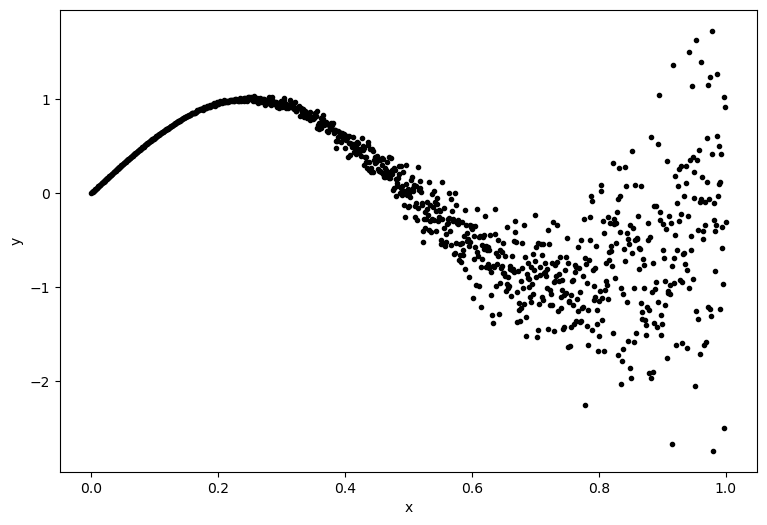

In [2]:
# Define some training data
train_x = torch.linspace(0, 1, 1000)
train_y = torch.sin(train_x * 2 * math.pi) + torch.randn(1000).mul(train_x.pow(3) * 1.0)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.scatter(train_x, train_y, c="k", marker=".", label="Data")
ax.set(xlabel="x", ylabel="y")


In [3]:
class ApproximateGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-1)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [4]:
import os

training_iterations = 50


In [10]:
# Our testing script takes in a GPyTorch MLL (objective function) class
# and then trains/tests an approximate GP with it on the supplied dataset


def train_and_test_approximate_gp(objective_function_cls):
    model = ApproximateGPModel(torch.linspace(0, 1, 10))
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    objective_function = objective_function_cls(
        likelihood, model, num_data=train_y.numel()
    )
    optimizer = torch.optim.Adam(
        list(model.parameters()) + list(likelihood.parameters()), lr=0.1
    )

    # Train
    model.train()
    likelihood.train()
    for _ in range(training_iterations):
        output = model(train_x)
        loss = -objective_function(output, train_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Test
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        f_dist = model(train_x)
        mean = f_dist.mean
        f_lower, f_upper = f_dist.confidence_region()
        y_dist = likelihood(f_dist)
        y_lower, y_upper = y_dist.confidence_region()

    # Plot model
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    (line,) = ax.plot(train_x, mean, "blue")
    ax.fill_between(
        train_x, f_lower, f_upper, color=line.get_color(), alpha=0.4, label="q(f)"
    )
    ax.fill_between(
        train_x, y_lower, y_upper, color=line.get_color(), alpha=0.2, label="p(y)"
    )
    ax.scatter(train_x, train_y, c="k", marker=".", label="Data")
    ax.legend(loc="best")
    ax.set(xlabel="x", ylabel="y")


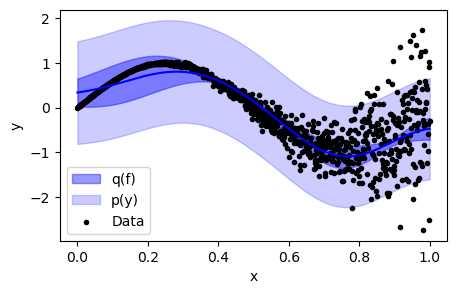

In [12]:
train_and_test_approximate_gp(gpytorch.mlls.VariationalELBO)


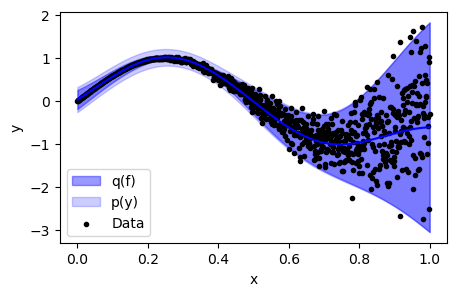

In [13]:
train_and_test_approximate_gp(gpytorch.mlls.PredictiveLogLikelihood)
